In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import normal_ad
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
import pmdarima as pm
from prophet import Prophet
import seaborn as sns
from scipy.stats import shapiro, anderson, kstest

df = pd.read_csv('covid.csv')

In [109]:
df['start_date'] = pd.to_datetime(df['start_date'], format='%Y-%m-%d')
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d')

# Выбор региона с большим количеством данных, например США
selected_region = 'United States'
region_df = df[df['region'] == selected_region].copy()

In [110]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
region_df = remove_outliers(region_df, 'covid_deaths_per_100k')
prophet_df = region_df[['start_date', 'covid_deaths_per_100k', 'population', 'excess_deaths']].copy()
prophet_df.columns = ['ds', 'y', 'population', 'excess_deaths']

# Проверка на наличие NaN. У меня почему-то появлялась ошибка даже после удаления
print("NaN values after cleaning:")
print(prophet_df.isna().sum())

NaN values after cleaning:
ds               0
y                0
population       0
excess_deaths    0
dtype: int64


In [111]:
train_size = int(len(prophet_df) * 0.8)
train_df = prophet_df[:train_size]
test_df = prophet_df[train_size:]

# Обучение модели Prophet с альтернативным методом оптимизации и дополнительными регрессорами
model_prophet = Prophet(seasonality_mode='multiplicative')
model_prophet.add_regressor('population')
model_prophet.add_regressor('excess_deaths')
model_prophet.fit(train_df, algorithm='Newton')

# Прогнозирование
future = model_prophet.make_future_dataframe(periods=len(test_df))
future['population'] = prophet_df['population'].values[:len(future)]
future['excess_deaths'] = prophet_df['excess_deaths'].values[:len(future)]

14:32:20 - cmdstanpy - INFO - Chain [1] start processing
14:32:20 - cmdstanpy - INFO - Chain [1] done processing


D:\Users\aomurbaeva\AppData\Local\anaconda3\envs\ds-course\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
D:\Users\aomurbaeva\AppData\Local\anaconda3\envs\ds-course\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


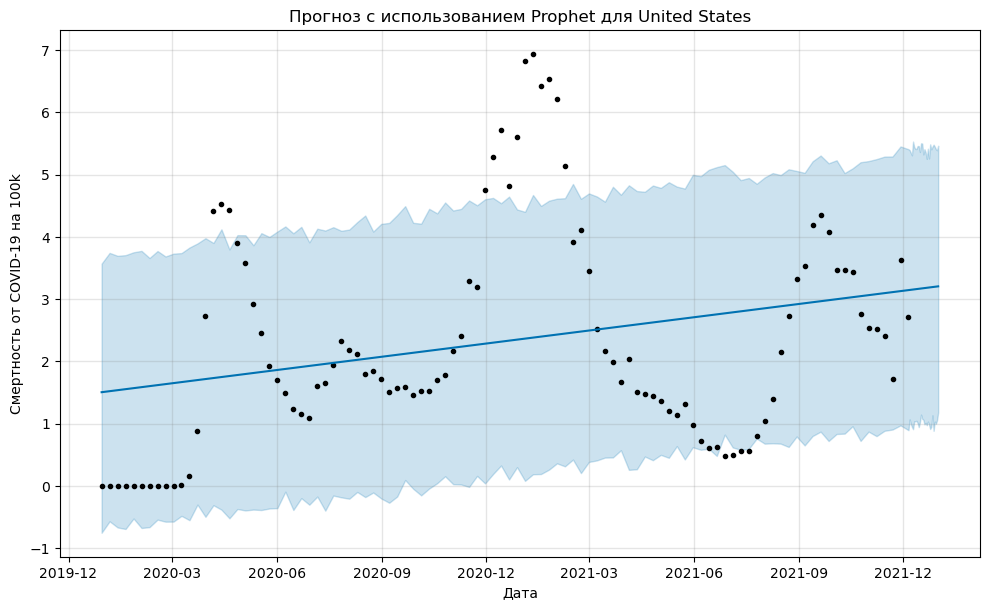

In [112]:
fig = model_prophet.plot(forecast_prophet)
plt.title(f'Прогноз с использованием Prophet для {selected_region}')
plt.xlabel('Дата')
plt.ylabel('Смертность от COVID-19 на 100k')
plt.show()

In [113]:
y_pred_prophet = forecast_prophet['yhat'].iloc[train_size:].values
r2_prophet = r2_score(test_df['y'], y_pred_prophet)
print(f'R2 Score for prophet: {r2_prophet}')
residuals_prophet = test_df['y'] - y_pred_prophet

R2 Score for prophet: -0.22101346181150605


Модель Prophet не подходит для данных этого датасета

In [114]:
# Бейзлайн-решение (прогноз на завтра — сегодняшнее количество)
baseline_pred = test_df['y'].shift(1).fillna(method='bfill')
r2_baseline = r2_score(test_df['y'], baseline_pred)
print(f'R2 Score for Baseline on Test Data: {r2_baseline}')
residuals_baseline = test_df['y'] - baseline_pred

R2 Score for Baseline on Test Data: 0.9256129502710257


D:\Users\aomurbaeva\AppData\Local\Temp\ipykernel_23884\2115944225.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  baseline_pred = test_df['y'].shift(1).fillna(method='bfill')


Базовая модель, которая предсказывает, что значение на следующий день будет таким же, как и сегодня, показывает высокий R2 Score. Это указывает на то, что значения временного ряда имеют сильную автокорреляцию.

In [115]:
window_size = 7
smoothed_series = prophet_df['y'].rolling(window=window_size).mean().dropna()

# Обновление prophet_df, чтобы убрать те строки, которые потерялись после сглаживания
prophet_df_smoothed = prophet_df.loc[smoothed_series.index]
prophet_df_smoothed['y'] = smoothed_series.values

# Разделение данных на обучающую и тестовую выборки после сглаживания
train_size_smoothed = int(len(prophet_df_smoothed) * 0.8)
train_df_smoothed = prophet_df_smoothed[:train_size_smoothed]
test_df_smoothed = prophet_df_smoothed[train_size_smoothed:]

# Обучение модели Prophet со сглаживанием
model_prophet_smoothed = Prophet(seasonality_mode='multiplicative')
model_prophet_smoothed.add_regressor('population')
model_prophet_smoothed.add_regressor('excess_deaths')
model_prophet_smoothed.fit(train_df_smoothed)

# Прогнозирование
future_smoothed = model_prophet_smoothed.make_future_dataframe(periods=len(test_df_smoothed))
future_smoothed['population'] = prophet_df_smoothed['population'].values[:len(future_smoothed)]
future_smoothed['excess_deaths'] = prophet_df_smoothed['excess_deaths'].values[:len(future_smoothed)]

forecast_prophet_smoothed = model_prophet_smoothed.predict(future_smoothed)

14:32:28 - cmdstanpy - INFO - Chain [1] start processing
14:32:33 - cmdstanpy - INFO - Chain [1] done processing


D:\Users\aomurbaeva\AppData\Local\anaconda3\envs\ds-course\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
D:\Users\aomurbaeva\AppData\Local\anaconda3\envs\ds-course\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


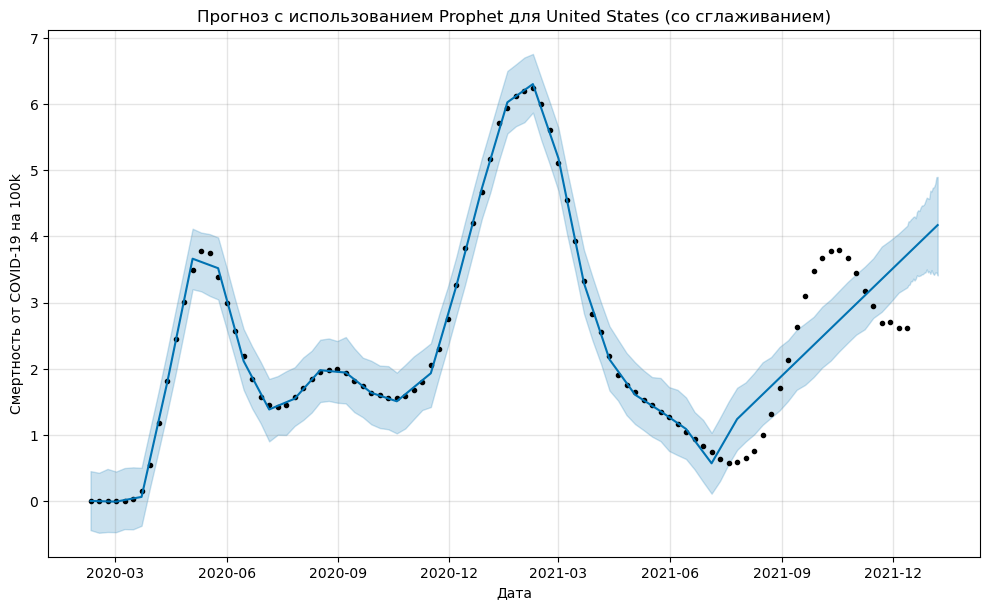

In [116]:
fig = model_prophet_smoothed.plot(forecast_prophet_smoothed)
plt.title(f'Прогноз с использованием Prophet для {selected_region} (со сглаживанием)')
plt.xlabel('Дата')
plt.ylabel('Смертность от COVID-19 на 100k')
plt.show()

In [117]:
y_pred_smoothed_prophet = forecast_prophet_smoothed['yhat'].iloc[train_size_smoothed:].values
r2_smoothed_prophet = r2_score(test_df_smoothed['y'], y_pred_smoothed_prophet)
print(f'R2 Score for Smoothed Prophet on Test Data: {r2_smoothed_prophet}')

R2 Score for Smoothed Prophet on Test Data: -1.045744192674415


Сглаженная модель Prophet работает значительно хуже, что говорит о том, что сглаживание данных не помогает в данной задаче.

In [121]:
def check_normality(residuals, model_name):
    print(f'\nNormality check for {model_name} residuals:')
    stat, p = shapiro(residuals)
    print(f'Shapiro-Wilk test: statistic={stat}, p-value={p}')
    if p > 0.05:
        print('Shapiro-Wilk test: Residuals seem to be normally distributed.')
    else:
        print('Shapiro-Wilk test: Residuals do not seem to be normally distributed.')

    result = anderson(residuals)
    print(f'Anderson-Darling test: statistic={result.statistic}')
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < cv:
            print(f'Anderson-Darling test: {sl}%: {cv}, data looks normal (fail to reject H0)')
        else:
            print(f'Anderson-Darling test: {sl}%: {cv}, data does not look normal (reject H0)')

    k2, p = kstest(residuals, 'norm')
    print(f'Kolmogorov-Smirnov test: statistic={k2}, p-value={p}')
    if p > 0.05:
        print('Kolmogorov-Smirnov test: Residuals seem to be normally distributed.')
    else:
        print('Kolmogorov-Smirnov test: Residuals do not seem to be normally distributed.')

    plt.figure()
    plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'Histogram of {model_name} Residuals')
    plt.show()
residuals_smoothed_prophet = test_df_smoothed['y'] - y_pred_smoothed_prophet


Normality check for Baseline residuals:
Shapiro-Wilk test: statistic=0.9791490612348481, p-value=0.8553725548096754
Shapiro-Wilk test: Residuals seem to be normally distributed.
Anderson-Darling test: statistic=0.26604916558870073
Anderson-Darling test: 15.0%: 0.516, data looks normal (fail to reject H0)
Anderson-Darling test: 10.0%: 0.587, data looks normal (fail to reject H0)
Anderson-Darling test: 5.0%: 0.705, data looks normal (fail to reject H0)
Anderson-Darling test: 2.5%: 0.822, data looks normal (fail to reject H0)
Anderson-Darling test: 1.0%: 0.978, data looks normal (fail to reject H0)
Kolmogorov-Smirnov test: statistic=0.21899619806448, p-value=0.14171508665360144
Kolmogorov-Smirnov test: Residuals seem to be normally distributed.


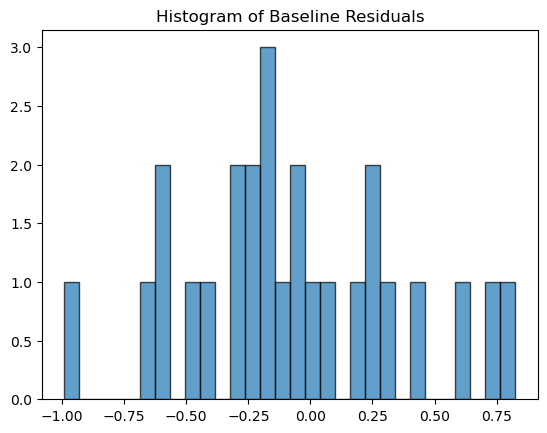

In [119]:
check_normality(residuals_baseline, 'Baseline')


Normality check for Prophet residuals:
Shapiro-Wilk test: statistic=0.887385850938045, p-value=0.008275483855198822
Shapiro-Wilk test: Residuals do not seem to be normally distributed.
Anderson-Darling test: statistic=0.9794946317896844
Anderson-Darling test: 15.0%: 0.516, data does not look normal (reject H0)
Anderson-Darling test: 10.0%: 0.587, data does not look normal (reject H0)
Anderson-Darling test: 5.0%: 0.705, data does not look normal (reject H0)
Anderson-Darling test: 2.5%: 0.822, data does not look normal (reject H0)
Anderson-Darling test: 1.0%: 0.978, data does not look normal (reject H0)
Kolmogorov-Smirnov test: statistic=0.4026668651210105, p-value=0.00025522444235031883
Kolmogorov-Smirnov test: Residuals do not seem to be normally distributed.


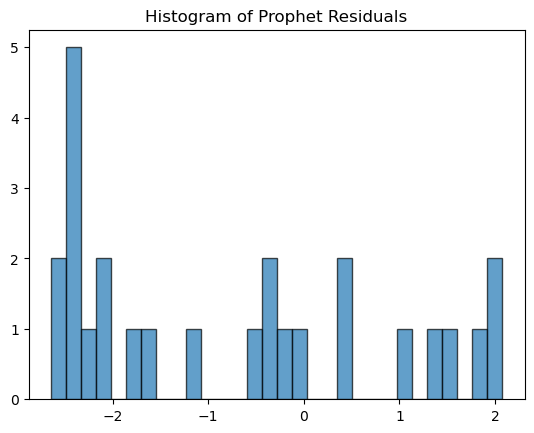

In [120]:
check_normality(residuals_prophet, 'Prophet')


Normality check for Smoothed Prophet residuals:
Shapiro-Wilk test: statistic=0.9037297449375543, p-value=0.022138147040870464
Shapiro-Wilk test: Residuals do not seem to be normally distributed.
Anderson-Darling test: statistic=0.7571591607173751
Anderson-Darling test: 15.0%: 0.514, data does not look normal (reject H0)
Anderson-Darling test: 10.0%: 0.586, data does not look normal (reject H0)
Anderson-Darling test: 5.0%: 0.703, data does not look normal (reject H0)
Anderson-Darling test: 2.5%: 0.82, data looks normal (fail to reject H0)
Anderson-Darling test: 1.0%: 0.975, data looks normal (fail to reject H0)
Kolmogorov-Smirnov test: statistic=0.3727925302265404, p-value=0.001256886157817938
Kolmogorov-Smirnov test: Residuals do not seem to be normally distributed.


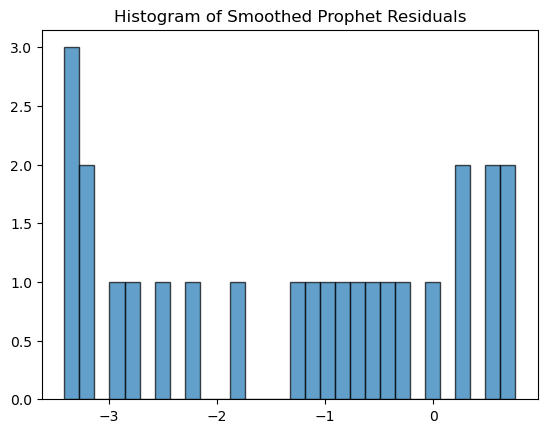

In [122]:
check_normality(residuals_smoothed_prophet, 'Smoothed Prophet')